# Whiteboarder

Whiteboarder is an interactive tool for processing whiteboard images: image clean-up, background removal, etc.



## Motivation

Main goal is obviously to have a task specific image processing studio for whiteboard capture pictures. A sub-goal is to explore how far Colab's little UI extensions can be pushed to make an end-user tool out of a notebook, with the code hidden but available for those brave souls who don't mind staring into the angry fruit salad.

## Dev POR and status

While surveying the prior art, found that there are lots of statistical image processing techniques for, say, white balancing but not whiteboards specifically. There are even learning-based solutions that get trained on a large dataset. But for specific whiteboard capture and clean-up, not much was found except Fred on ImageMagick.


So, let's test drive some of the prior art and then get into some hand crafting of modern ML tools. Then it's time for pure Python image manipulation. Python has a lot of very nice and easy to use libraries.


 Tensoflow models on TFX Pipelines, etc. See if Google image search can get a ton of images to train on. Then use non-learning image segmentation techniques to generate training masks for a CNN which will be trained to remove whiteboard background white-ish field.

More potential ML e.g.s: 
- Whiteboard frame detector and image aligner
- Smarter clean-up:VAE, autoencoders
- OCR
- Flowchart recognizer would be next level


## History

2020-04-22:
- Start with OpenCV experiments

2020-04-21:
- Started notebook
- Got some Fred on ImageMagick working but not great at all
  - Halogen yellow is background and fucks with red ink


# Colab VM config

Colab come seriously preloaded with tons of great toys but one or two need to be explicitly added to a running VM (which will be killed off within 12 hours). Let's just get all that out of the way at the start.


## Installations

In [1]:
!apt -qq install -y imagemagick # mouthy install!
!apt -q install bc # Fred's whiteboard wants this

!apt -q install tree

The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts imagemagick
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsi

## ** Imports

This is the place to start for re-runs after `Runtime` => `Restart Runtime`. Rather than `Run all` choose `Run after` to bypass slow installs above here.

In [0]:
import PIL
import PIL.Image
from IPython.display import display
import cv2
import google.colab



from matplotlib import pyplot as plt


## File system workspace

A simple organized workspace on the file system makes for cleaner, more efficient code: e.g. enable a download caching mechanis, useful during frequent restarts as can happen (by design) on Colab.

This notebook will only (intentionally) create files in directory, `/content/whiteboarder/`.

- `/`: file system root
  - `content/`: default home/pwd on Colab 
    - `whiteboarder/`: this notebooks workspace
      - `cache/`: an organized downloads
      - `built/`: output of the notebook
        - various images

In [0]:
workspace_root_path = '/content/whiteboarder/' # /content is Colab's default dir

# TODO: Python all the rest?
!rm -r sample_data/ # Don't need it. Noise.
!mkdir {workspace_root_path} # Put everything in here


## Google Drive

It is very easy to mount one's Google Drive to a Colab VM's file system. (Due to the 12 hour limit of Colab VM's, daily sign-in re-mounting is a brief rigmarole.)

Additional there are tons of way to integrate client devices with Google Drive. 

Python downloading from gDrive make for notebooks that re-run well. Repeatedly manually uploading files is a drag; that's much more of a hassle than having to re-login once a day or so.

So, for the above two reasons gDrive makes for a fine repository and relay point for images.

In [4]:
# Mount googld drive

gdrive_dir_name = workspace_root_path + 'gdrive'
google.colab.drive.mount(gdrive_dir_name)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/whiteboarder/gdrive


In [5]:
ls -lh {gdrive_dir_name}

total 4.0K
drwx------ 5 root root 4.0K Apr 22 18:12 'My Drive'/


In [0]:
gdrive_data_root_path = gdrive_dir_name + '/My Drive/Professional/Reconstrue/Whiteboard/2020/2020-04/'

Annoyingly there's a space in the dir name `/My Drive/` so quoting is in order.

In [7]:
!tree -L 5 "{gdrive_data_root_path}"

/content/whiteboarder/gdrive/My Drive/Professional/Reconstrue/Whiteboard/2020/2020-04/
├── plotting_knee_error.jpg
├── plotting_knee_error_low_temped.png
└── whiteboard

0 directories, 3 files


Note that file `whiteboard` which is a bash shell downloaded from [Fred](http://www.fmwconcepts.com/imagemagick/downloadcounter.php?scriptname=whiteboard&dirname=whiteboard). That is his unmodified code used here in this non-commercial notebook. It's cached to help this page init smoothly.


In [8]:
freds_whiteboard_file_name = gdrive_data_root_path + '/whiteboard'
!head -n 4 "{freds_whiteboard_file_name}"

#!/bin/bash
#
# Developed by Fred Weinhaus 5/29/2009 .......... revised 5/7/2015
#


# ImageMagick

The immortal cockroach know as ImageMagick.

TODO:
- `!cli -call_to` imagemagick
- Python to ImageMagick
  - [wand](http://docs.wand-py.org/en/0.5.9/)
  - PythonMagick


## Fred's Whiteboard

Years ago, Fred Weinhaus cranked out the tool which originally inspired this notebook to happen. His script, [Whiteboard](http://www.fmwconcepts.com/imagemagick/whiteboard/index.php), is described as "Processes a picture of a whiteboard to clean up the background and correct the perspective." Old but nonetheless it was "last modified: December 16, 2018" so it is also long maintained.

In [0]:
# TODO: this fails. A file is created but not usable.
#!wget -O freds_whiteboard http://www.fmwconcepts.com/imagemagick/downloadcounter.php?scriptname=whiteboard&dirname=whiteboard


#But download from fmwconcepts.com, cache in private gDrive, download same to Colab FS works.
# That's why it's cached in freds_whiteboard_file_name.
#So install is just a cp

freds_dest = workspace_root_path + 'whiteboard' # whiteboard is file's orig name

!cp "{freds_whiteboard_file_name}" {freds_dest}

#!cp /content/whiteboarder/gdrive/My Drive/Professional/Reconstrue/Whiteboard/2020/2020-04/whiteboard

In [10]:
# Debug
print(freds_whiteboard_file_name)
print(freds_dest)

/content/whiteboarder/gdrive/My Drive/Professional/Reconstrue/Whiteboard/2020/2020-04//whiteboard
/content/whiteboarder/whiteboard


In [11]:
print(workspace_root_path)
!ls -lh {workspace_root_path} 

/content/whiteboarder/
total 36K
drwx------ 4 root root 4.0K Apr 22 18:12 gdrive
-rw------- 1 root root  29K Apr 22 18:12 whiteboard


In [0]:
!chmod u+x {freds_dest}

In [0]:
in_file = gdrive_data_root_path + 'plotting_knee_error_low_temped.png'

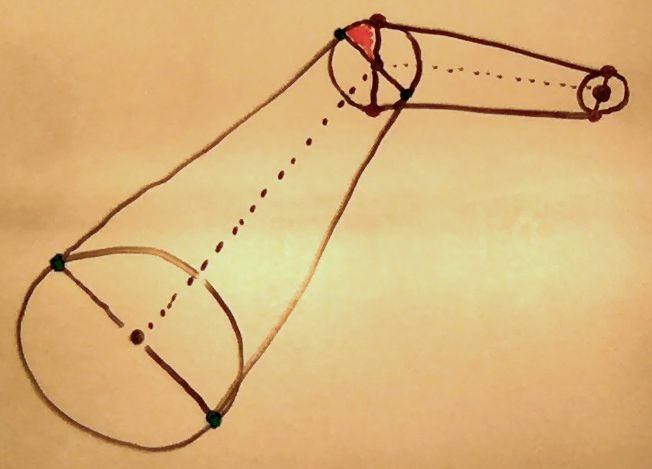

In [14]:
in_img = PIL.Image.open(in_file)
display(in_img)

In [0]:
!bash {freds_dest} -o 33 -e none -f 10 -S 150 -p 0.1 "{in_file}" out.jpg

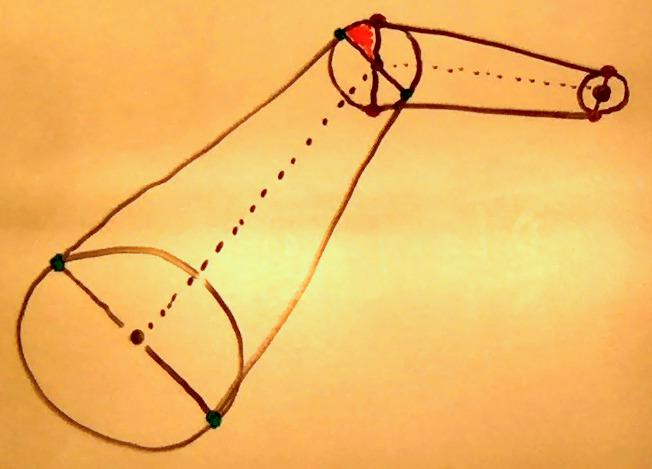

In [16]:
out_img = PIL.Image.open("out.jpg")
display(out_img)

In [0]:
# how to download files.download("out.jpg")

# OpenCV

OpenCV seems to be a widely adopted tool in the Python community and `cv2` is pre-installed on Colab so…

Here's someone who has already gone through the OpenCV on Colab tire kicking:
[Computer Vision - Instructional Exercise](https://colab.research.google.com/drive/1RWGmqoEQdeyh5TssoGtsXsFk8hbLGtWp). The next few cells repro those notes in the context of there here whiteboard images.

There seems to be a hassle on Colab WRT OpenCV. OpenCV used BGR color order, the reverse of the web's RGB order from HTML and CSS. But Colab doesn't like OpenCV's display utilities so we need to use something else, necessitating a translation from BRG => RGB.

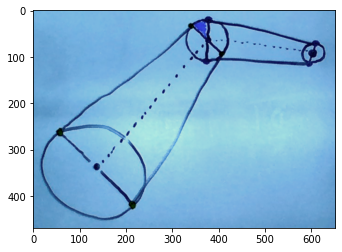

In [27]:
cv2_img = cv2.imread(in_file)
# Here's the show-with-something-else bit: Matplotlib
plt.imshow(cv2_img)
plt.show()

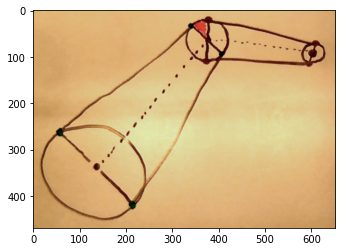

In [30]:
# cv2 BGR => normal world RGB => MPL show()
def show_cv2_img(a_cv2_img):
  imgrgb = cv2.cvtColor(a_cv2_img, cv2.COLOR_BGR2RGB)
  plt.imshow(imgrgb)
  plt.show()

show_cv2_img(cv2_img)


## Simple White Balance
- https://stackoverflow.com/a/49481583/4669056
  - https://gist.github.com/DavidYKay/9dad6c4ab0d8d7dbf3dc

### Xphoto
https://stackoverflow.com/a/49836244/4669056:

>The answer can be found in [the xphoto documentation](https://docs.opencv.org/3.4.1/df/db9/namespacecv_1_1xphoto.html)
.  
>The appropriate methods to create the WB algorithms are createSimpleWB(), createLearningBasedWB() and createGrayworldWB().  
> &nbsp;   
>Example:
```python
wb = cv2.xphoto.createGrayworldWB()
wb.setSaturationThreshold(0.99)
image = wb.balanceWhite(image)
```


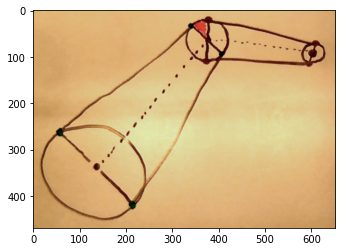

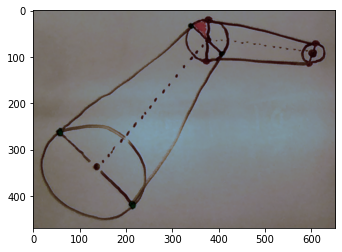

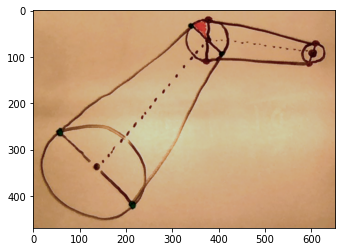

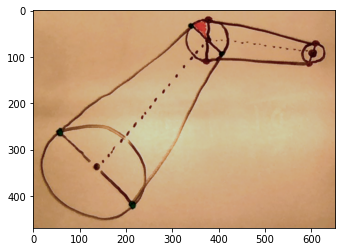

In [38]:
gray_wb = cv2.xphoto.createGrayworldWB()
gray_wb.setSaturationThreshold(0.99)
gray_img = gray_wb.balanceWhite(cv2_img)

simple_wb = cv2.xphoto.createSimpleWB()
simple_img = simple_wb.balanceWhite(cv2_img)

learning_wb = cv2.xphoto.createLearningBasedWB()
learning_img = learning_wb.balanceWhite(cv2_img)

show_cv2_img(cv2_img)
show_cv2_img(gray_img)
show_cv2_img(learning_img)
show_cv2_img(balanced_img)


## Learning white balance

https://docs.opencv.org/master/dc/dcb/tutorial_xphoto_training_white_balance.html

>Many traditional white balance algorithms are statistics-based, i.e. they rely on the fact that certain assumptions should hold in properly white-balanced images like the well-known grey-world assumption. However, better results can often be achieved by leveraging large datasets of images with ground-truth illuminants in a learning-based framework. This tutorial demonstrates how to train a learning-based white balance algorithm and evaluate the quality of the results.

# Appendices

## How to upload files
```python
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
```